# Recurrent Neural Network forecasting

- Reference:`keras.layers.SimpleRNN`

**Basic Architecture diagram**  

<img src="./pic/RNN.png" alt="RNN Architecture" width="500"/>

- U,V,W are weight matrix.
- Input: vector $X_t$ is input for network at time step t.  
- Hidden state: vector $h(t)=\tanh \left(W h(t-1)+U_{x}(t)\right)$
- Output: $y_t$ is the output for the network at time step t. $y_t=\operatorname{softmax}(V s(t))$

Every neuron is assigned to a fixed step. The output of the hidden layer of one time step is part of the input of next time step.

- The algorithm is to find the optimal weight matrix U,V,W that gives the best prediction or minimizes the loss function $J$. 
$$J(\theta)=\frac{1}{m} \sum_{i=1}^{m} \sum_{t=1}^{N_{i}} D(y_t, Y_t)$$
- Forward/Backward propagation

## Vanishing gradiant problems

- LSTM `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
- GRU `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

## RNN Crypto-forcasting

In [1]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

print(tf.__version__)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

2.6.0
Num GPUs Available:  1


In [93]:
##data and date
csv_path = '/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/codetest/btc.csv'
df = pd.read_csv(csv_path)
df = df[-70000:]
date_time = pd.to_datetime(df.pop('timestamp'),unit='s')
df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1886282,1,1009.0,38463.446686,38484.00,38405.18,38428.484286,34.940985,38451.705205,0.000094
1886283,1,935.0,38423.084753,38467.72,38408.31,38453.424286,23.979506,38434.534545,-0.000699
1886284,1,946.0,38458.731429,38500.40,38447.64,38484.997143,38.255848,38479.665203,-0.000319
1886285,1,699.0,38482.981429,38497.00,38439.62,38463.950000,24.634812,38467.956129,0.000082
1886286,1,671.0,38457.484286,38503.00,38439.63,38491.732857,19.218220,38470.259211,-0.000140


## Split the data

split for the training(70%), validation(20%), and test sets(10%). See section **overfitting**.

In [100]:
from sklearn.model_selection import train_test_split

df = df[['Count','Open','High','Low','Close','Volume','VWAP']]
#train, validation sets
train_df,val_df = train_test_split(df,train_size=0.70,test_size=0.20,shuffle=False)
#holdout/test sets
n = len(df) #rows
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data
scale features before training a neural network

In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Data for LSTM: windowing and prediction conditions

The models make a set of predictions based on a window of consecutive samples from the data.
- The `width` (number of time steps) of the `input` and `label` windows.
- The `shift=offset` between them.
- Which `features` are used as `inputs`, `labels`, or both.

Example: to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:
<img src="./pic/raw_window_24h.png" alt="window24_24" width="500"/>



In [5]:
from script.RNN.window import WindowGenerator
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Close'])
    
wide_window

Input width=30,Label width=30,Offset width=1
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Close']

The data used for training the model is formated as `tf.data.Dataset` which is splited into inputs and labels. Similarly for valuation, test and example data.

In [6]:
wide_window.train

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-11-15 21:51:30.180963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-15 21:51:30.181072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<MapDataset shapes: ((None, 30, 7), (None, 30, 1)), types: (tf.float32, tf.float32)>

## Long Short-Term Memory  
<img src="./pic/LSTM-1.png" alt="LSTM Architecture" width="500"/> 

- [https://keras.io](https://keras.io)
- ` tf.keras.layers.LSTM`
- `return_sequence=True`, it will return something with shape: `(batch_size, timespan, unit)`. 
- `return_sequence=False`, then it just return the last output in shape `(batch_size, unit)`.


### Model Design
- `LSTM(units = 20)`: LSTM layer with 20 internal units.
- `Dense(units=2)`: Dense layer with 2 units.
- Choose units by cross validation.

Graph below demonstrates what layer and unit (or neuron) are, and the rightmost image shows the internal structure of a single LSTM unit.
<img src="./pic/lstm-units.png" alt="lstmunits" width="500"/>

In [7]:
import tensorflow as tf
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 20, return_sequences=True,
                        activation='tanh', recurrent_activation='sigmoid'),#Recurrent layers
    tf.keras.layers.Dense(units=1)#densely-connected NN layer: output with dim-1
])
IPython.display.clear_output()

In [8]:
print('Input shape:', wide_window.example[0].shape)#[batch_size, timesteps, feature]
print('Output shape:', lstm_model(inputs= wide_window.example[0]).shape)
print('Label shape:', wide_window.example[1].shape)

Input shape: (32, 30, 7)


2021-11-15 21:51:30.291395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 21:51:30.291605: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Output shape: (32, 30, 1)
Label shape: (32, 30, 1)


In [9]:
val_performance={}
performance={}

### Fitting
- `compile_and_fit()`: do `model.compile`, `model.fit`, `TensorBoard`

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

In [11]:
from script.RNN.compilefit import compile_and_fit
history = compile_and_fit(model = lstm_model, window = wide_window, 
                            MAX_EPOCHS = 10)
##could increase MAX_EPOCHS to minimize errors and detail the learning curves.
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
IPython.display.clear_output()

### Visualization the architecture
- `lstm_model.summary()`
- Graphs dashboard

```python
#Op-level graph
%tensorboard --logdir logs
```

In [12]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            2240      
_________________________________________________________________
dense (Dense)                (None, 30, 1)             21        
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


### Prediction

We use one batch in the training inputs(`wide_window.train`) as example(`wide_window.example`) for showing the prediction.

In [72]:
pred_inputs, pred_label = wide_window.example
print(pred_inputs.shape,pred_label.shape)

(32, 30, 7) (32, 30, 1)


In [73]:
pred_result = lstm_model(pred_inputs)#the first sample in the batch, 30 minutes prediction on the close price.
print(pred_result.shape)

(32, 30, 1)


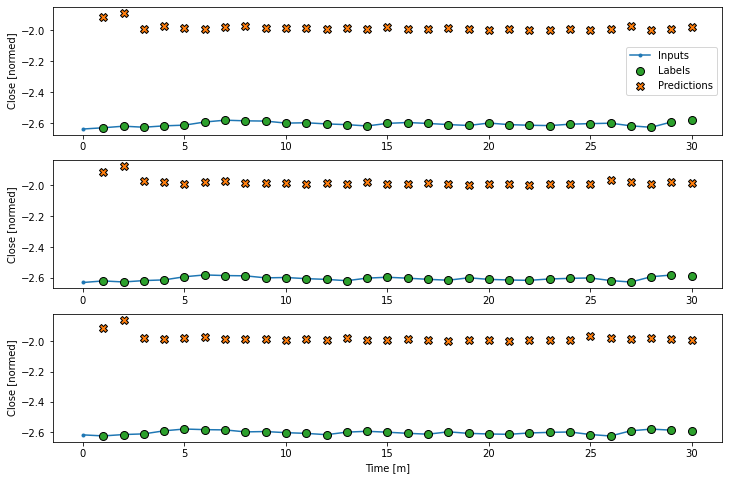

In [74]:
wide_window.plot(lstm_model)

### Prediction RMSE

In [77]:
from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_result[0,:,:],pred_label[0,:,:]))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.6234675645828247


Or we give it 1 sample of future 30minutes' info to do prediction.

In [39]:
future_inputs = tf.random.normal([1,30,7], 0, 1, tf.float32, seed=1)#tf.tensor type
future_inputs =  np.random.randn(1,30,7)#or numy.array type
lstm_model(future_inputs)

<tf.Tensor: shape=(1, 30, 1), dtype=float32, numpy=
array([[[-0.48907566],
        [-0.25456318],
        [-0.14492428],
        [-0.01028365],
        [-0.45238632],
        [ 0.19093943],
        [ 0.09443693],
        [-0.9880432 ],
        [ 0.7215243 ],
        [ 0.1271223 ],
        [ 0.46105027],
        [ 0.30882785],
        [-0.89925545],
        [ 0.16099112],
        [ 0.5720198 ],
        [ 1.2608664 ],
        [-0.6327335 ],
        [-0.12736323],
        [-0.0352786 ],
        [ 0.07808818],
        [ 0.3562093 ],
        [-0.0592061 ],
        [ 0.8046787 ],
        [ 0.6939298 ],
        [-0.21167266],
        [ 0.47733265],
        [ 0.71961904],
        [-0.14399536],
        [ 0.7860952 ],
        [-0.5642217 ]]], dtype=float32)>

## Save the trained LSTM

```
# save neural network structure to JSON (no weights)
model_json = lstm_model.to_json()
with open(os.path.join(save_path,"network.json"), "w") as json_file:
    json_file.write(model_json)

# save neural network structure to YAML (no weights)
model_yaml = lstm_model.to_yaml()
with open(os.path.join(save_path,"network.yaml"), "w") as yaml_file:
    yaml_file.write(model_yaml)

```

In [80]:
# save entire network to HDF5 (save everything, suggested)
save_path = save_path = "./trainedNN"
lstm_model.save(os.path.join(save_path,"lstm-notebook.h5"))

In [83]:
lstm_model_reload = tf.keras.models.load_model(os.path.join(save_path,"lstm-notebook.h5"))
pred_result_reload = lstm_model_reload(pred_inputs)#the first sample in the batch, 30 minutes prediction on the close price.
score = np.sqrt(metrics.mean_squared_error(pred_result_reload[0,:,:],pred_label[0,:,:]))
print(f"Final score (RMSE): {score}")
#should be same as above

Final score (RMSE): 0.6234675645828247


## Overfitting and Early Stopping 

It is important to segment the original dataset into several datasets(already done in the previous section):

* **Training Set** : `wide_window.train`
* **Validation Set** : `wide_window.val`
* **Holdout Set**: `wide_window.test`

The training data(`wide_window.train`) are used to train the neural network until the validation set no longer improves.  This attempts to stop at a near optimal training point.  This method will only give accurate "**out of sample**" predictions for the validation set(`wide_window.val`), this is usually 20% or so of the data.  The predictions for the training data will be overly optimistic, as these were the data that the neural network was trained on.

I design this data split method in the class `WindowGenerator` as shown in section data windowing. The model fitting takes the early stopping through `tf.keras.callbacks.EarlyStopping`.

I design the earlystopping based on validation set as:

```python
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',restore_best_weights=False)
```

- details: [https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)